In [10]:
from IPython.display import display

import numpy as np
import pandas as pd

# Load data similar to machine_learning.ipynb
from preprocess import load_and_process

data, image_id = load_and_process()

/home/aris/anaconda3/envs/torch/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
# Define SDRM score according to the formula

# Max spreading rate of the queen of the Asian Giant Hornet is 30 km per year
MAX_SPREADING_RATE = 30

# The first verified Positive ID is at (-123.943134, 49.149394) on 9/19/2019(t=-104)
# with GlobalID={124B9BFA-7F7B-4B8E-8A56-42E067F0F72E},
# which is used as the original point.
X_0 = -123.943134
Y_0 = 49.149394
T_0 = -104

# Constant used to convert coordinate degree into km
KM_PER_DEGREE = 111

In [4]:
# Define the function to calculate distance between to Coordinate
import numpy as np

def distance(x, y):
    d_x = x - X_0
    d_y = y - Y_0

    d_x_km = d_x * KM_PER_DEGREE
    d_y_km = d_y * np.cos(np.abs(x) / 180 * np.pi)

    return np.sqrt(d_x_km ** 2 + d_y_km ** 2)

In [35]:
# Calculate the sdrm_score with
# sdrm_scroe
import scipy.stats as st

def sdrm_score(x, y, t):
    max_displacement = MAX_SPREADING_RATE * (t - T_0 + 1e-6) / 365
    ratio = max(min(distance(x, y) / max_displacement, 1), 0)
    score = 1- (st.norm.cdf(ratio) - 0.5) * 2
    return score

In [36]:
# Re-label all data
n = data.shape[0]

y_pred_sdrm = np.zeros(n)

for i in range(n):
    y_pred_sdrm[i] = sdrm_score(data.loc[data.index[i], 'Longitude'], data.loc[data.index[i], 'Latitude'], data.loc[data.index[i], 'Detection Date'])

y_pred_sdrm = pd.DataFrame(y_pred_sdrm.reshape((-1,1)), index=data.index, columns=['sdrm_score'])

In [37]:
y_pred_sdrm.to_csv('y_pred_sdrm.csv')

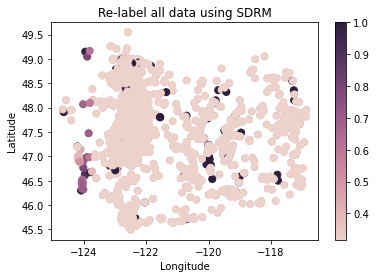

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

cmap = sns.cubehelix_palette(as_cmap=True)
# Plot the re-labeled dataset

f, ax = plt.subplots()

plt.scatter(data['Longitude'], data['Latitude'], c=y_pred_sdrm['sdrm_score'])
points = ax.scatter(data['Longitude'], data['Latitude'], c=y_pred_sdrm['sdrm_score'], s=50, cmap=cmap)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Re-label all data using SDRM")
f.colorbar(points)

plt.savefig('fig/re-labeled_sdrm.png')